In [ ]:
import pandas as pd
# 加载训练集和测试集(相对路径)
train = pd.read_csv('train.csv')
test = pd.read_csv('testA.csv')
import numpy as np


# 数据精度量化压缩
def reduce_mem_usage(df):
    # 处理前 数据集总内存计算
    start_mem = df.memory_usage().sum() / 1024**2 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    # 遍历特征列
    for col in df.columns:
        # 当前特征类型
        col_type = df[col].dtype
        # 处理 numeric 型数据
        if col_type != object:
            c_min = df[col].min()  # 最小值
            c_max = df[col].max()  # 最大值
            # int 型数据 精度转换
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            # float 型数据 精度转换
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # 处理 object 型数据
        else:
            df[col] = df[col].astype('category')  # object 转 category
    
    # 处理后 数据集总内存计算
    end_mem = df.memory_usage().sum() / 1024**2 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df



# 训练集特征处理与精度量化
train_list = []
for items in train.values:
    train_list.append([items[0]] + [float(i) for i in (items[1].split(','))] + [items[2]])
train = pd.DataFrame(np.array(train_list))
train.columns = ['id'] + [str(i) for i in range(len(train_list[0])-2)] + ['label']  # 特征分离
train = reduce_mem_usage(train)  # 精度量化
train=train.drop(["id"],axis=1)

# 测试集特征处理与精度量化
test_list=[]
for items in test.values:
    test_list.append([items[0]] + [float(i) for i in items[1].split(',')])
test = pd.DataFrame(np.array(test_list))
test.columns = ['id'] + [str(i) for i in range(len(test_list[0])-1)]  # 特征分离
test = reduce_mem_usage(test)  # 精度量化







Memory usage of dataframe is 157.93 MB
Memory usage after optimization is: 39.67 MB
Decreased by 74.9%
Memory usage of dataframe is 31.43 MB
Memory usage after optimization is: 7.90 MB
Decreased by 74.9%


#### 数据分布不均衡，需要进行重新采样

In [ ]:
train[train.columns[-1]].value_counts()

0.0    64327
3.0    17912
2.0    14199
1.0     3562
Name: label, dtype: int64

In [ ]:
# from sklearn.utils import resample
# train_1=train[train
#         ["label"]==0]
# train_2=train[train["label"]==1]
# train_3=train[train["label"]==2]
# train_4=train[train["label"]==3]

# train_1_upsample=resample(train_1,replace=True,n_samples=25000,random_state=123)
# train_2_upsample=resample(train_2,replace=True,n_samples=25000,random_state=124)
# train_3_upsample=resample(train_3,replace=True,n_samples=25000,random_state=125)
# train_4_upsample=resample(train_4,replace=True,n_samples=25000,random_state=126)
# ## resample 之后拼接
# train=pd.concat([train_1_upsample,train_2_upsample,train_3_upsample,train_4_upsample])

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=2021, n_jobs=-1)
y_train = train['label']
x_train = train.drop(['label'], axis=1)
X, Y = smote.fit_resample(x_train, y_train) 

# Test part

In [ ]:
 from sklearn.model_selection import train_test_split

In [ ]:
 X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, random_state=11)

## 训练神经网络

In [ ]:
from keras.utils.np_utils import to_categorical
Y_train=to_categorical(y_train,4)
Y_test=to_categorical(y_test,4)

In [ ]:
import numpy as np

In [ ]:
X_train =np.array(X_train).reshape(len(X_train), X_train.shape[1],1)
X_test = np.array(X_test).reshape(len(X_test), X_test.shape[1],1)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(205846, 205, 1)
(51462, 205, 1)


In [ ]:
## define input size
feature_num = X_train.shape[1]


In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D,BatchNormalization,Flatten,MaxPool1D,Dense,Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dropout



In [ ]:

# model=Sequential()
# input=(feature_num,1)
# model.add(Conv1D(32,(3),strides=(1),padding='same',activation='relu',input_shape=input))
# model.add(BatchNormalization())
# model.add(MaxPool1D(2))
# model.add(Dropout(0.5))

# model.add(Conv1D(64,(3),strides=(1),padding='same',activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPool1D(2))
# model.add(Dropout(0.5))

# model.add(Conv1D(64,(3),strides=(1),padding='same',activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPool1D(2))
# model.add(Dropout(0.5))

# model.add(Flatten())

# model.add(Dense(512,activation='relu', kernel_initializer='he_normal'))
# model.add(Dense(4,activation='softmax'))


model=Sequential()
input=(feature_num,1)


model.add(Conv1D(16,(3),strides=(1),padding='same',activation='relu',input_shape=input))
model.add(Conv1D(32,(3),strides=(1),dilation_rate=2,padding='same',activation='relu'))
model.add(Conv1D(64,(3),strides=(1),dilation_rate=2,padding='same',activation='relu'))
model.add(Conv1D(64,(3),strides=(1),dilation_rate=2,padding='same',activation='relu'))
model.add(MaxPool1D(3,2,padding='same'))

model.add(Conv1D(128,(5),dilation_rate=2,padding='same',activation='relu'))
model.add(Conv1D(128,(5),dilation_rate=2,padding='same',activation='relu'))
model.add(MaxPool1D(3,2,padding='same'))

model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(256,activation='relu', kernel_initializer='he_normal'))
model.add(Dense(4,activation='softmax'))


In [ ]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_87 (Conv1D)          (None, 205, 16)           64        
                                                                 
 conv1d_88 (Conv1D)          (None, 205, 32)           1568      
                                                                 
 conv1d_89 (Conv1D)          (None, 205, 64)           6208      
                                                                 
 conv1d_90 (Conv1D)          (None, 205, 64)           12352     
                                                                 
 max_pooling1d_41 (MaxPoolin  (None, 103, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_91 (Conv1D)          (None, 103, 128)          41088     
                                                     

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

history=model.fit(X_train, Y_train,epochs=30,callbacks=callbacks, batch_size=64,validation_data=(X_test,Y_test))

Epoch 1/30
3217/3217 [==============================] - 63s 19ms/step - loss: 0.1121 - accuracy: 0.9599 - val_loss: 0.0454 - val_accuracy: 0.9846
Epoch 2/30
3217/3217 [==============================] - 61s 19ms/step - loss: 0.0364 - accuracy: 0.9879 - val_loss: 0.0252 - val_accuracy: 0.9916
Epoch 3/30
3217/3217 [==============================] - 61s 19ms/step - loss: 0.0247 - accuracy: 0.9917 - val_loss: 0.0133 - val_accuracy: 0.9957
Epoch 4/30
3217/3217 [==============================] - 66s 21ms/step - loss: 0.0194 - accuracy: 0.9937 - val_loss: 0.0125 - val_accuracy: 0.9964
Epoch 5/30
3217/3217 [==============================] - 61s 19ms/step - loss: 0.0162 - accuracy: 0.9949 - val_loss: 0.0099 - val_accuracy: 0.9969
Epoch 6/30
3217/3217 [==============================] - 61s 19ms/step - loss: 0.0133 - accuracy: 0.9959 - val_loss: 0.0093 - val_accuracy: 0.9973
Epoch 7/30
3217/3217 [==============================] - 61s 19ms/step - loss: 0.0121 - accuracy: 0.9962 - val_loss: 0.0120 -

In [ ]:
print(1)

1


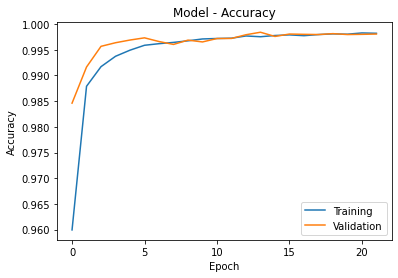

In [ ]:
import matplotlib.pyplot as plt
y_pred=model.predict(X_test)
fig1, ax_acc = plt.subplots()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model - Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

In [ ]:
target_names=['0','1','2','3']
import numpy as np
from sklearn.metrics import confusion_matrix 
y_true=[]
for element in Y_test:
    y_true.append(np.argmax(element))
prediction_proba=model.predict(X_test)
prediction=np.argmax(prediction_proba,axis=1)
prediction.reshape(len(prediction),1)
cnf_matrix = confusion_matrix(y_true, prediction)

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Normalized confusion matrix


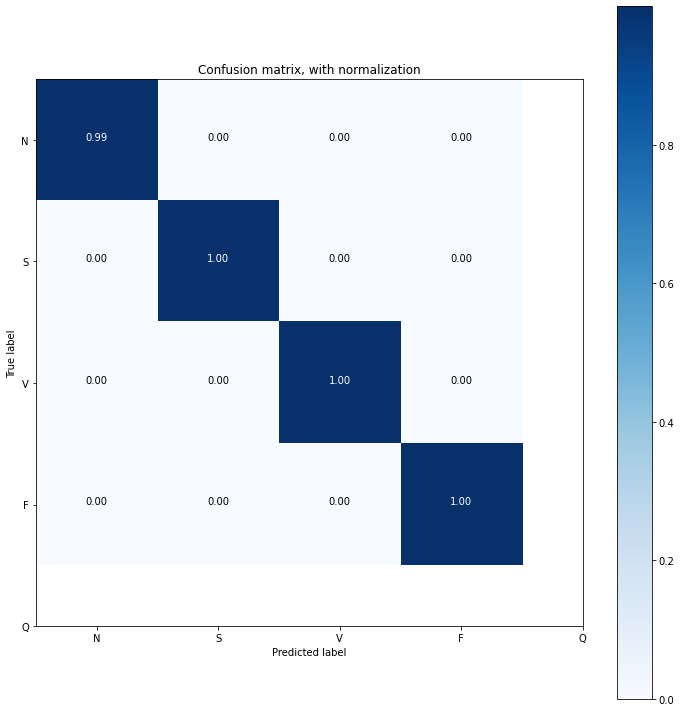

In [ ]:
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

### try to predict and save data 

In [ ]:
My_X_test=test.drop(["id"],axis=1)


In [ ]:
prediction_proba=model.predict(My_X_test)
prediction_proba

array([[1.0000000e+00, 1.2514762e-14, 7.6562137e-17, 6.4910835e-16],
       [2.8000056e-22, 2.4415691e-19, 1.0000000e+00, 3.3234375e-16],
       [6.8371584e-35, 0.0000000e+00, 1.9197079e-28, 1.0000000e+00],
       ...,
       [2.5364534e-08, 1.8107075e-11, 1.0000000e+00, 5.1705571e-19],
       [1.0000000e+00, 2.9100869e-17, 1.5879632e-22, 6.9124371e-24],
       [9.8071575e-01, 1.1174953e-06, 7.1061069e-05, 1.9212022e-02]],
      dtype=float32)

In [ ]:
df=pd.DataFrame( prediction_proba)

In [ ]:
df.index.name = "id"
df.columns=["label_0","label_1","label_2","label_3"]
df.index=df.index+100000

In [ ]:
df

,label_0,label_1,label_2,label_3
id,,,,
100000,1.000000e+00,1.251476e-14,7.656214e-17,6.491083e-16
100001,2.800006e-22,2.441569e-19,1.000000e+00,3.323438e-16
100002,6.837158e-35,0.000000e+00,1.919708e-28,1.000000e+00
100003,1.000000e+00,1.026590e-20,7.999630e-15,1.791677e-17
100004,1.000000e+00,2.735011e-35,2.842503e-23,3.073114e-24
...,...,...,...,...
119995,9.999177e-01,1.414580e-06,8.087269e-05,5.266338e-14
119996,1.000000e+00,7.320583e-12,4.518622e-19,6.272200e-32
119997,2.536453e-08,1.810707e-11,1.000000e+00,5.170557e-19


In [ ]:
df.to_csv("ECG_result.csv")